In [1]:
import numpy as np
import control as ct
import matplotlib.pyplot as plt
import scienceplots

# Configurações de plot:
plt.style.use([
    'grid',
    'retro'
])
plt.rcParams['lines.linewidth'] = 2
plt.rcParams['font.size'] = 20
plt.rcParams['figure.figsize'] = (12, 5)

In [2]:
#Criação da onda quadrada por Série de Fourier:
def PWM(time, amplitude, duty, freq=1e3):
    output = np.ones(time.shape)*(amplitude*duty)
    freq *= 1000
    time -= ((duty+0.01)/(2*freq))
    n = 1e4
    for k in range(1, int(n+1)):
        output += (((2*amplitude)/(k*np.pi))*np.sin(k*np.pi*duty)*np.cos(2*freq*k*np.pi*time))
    return output

#Função para avaliar uma FT em determinada frequência:
def lim(FT, s):
    #Módulo do sistema avaliado no polo desejado:
    D = FT.den[0][0]
    N = FT.num[0][0]
    A = np.empty(len(D), dtype=np.complex_)
    for i in range(len(D)):
        A[i] = np.power(s, (len(D)-i-1))
    B = np.empty(len(N), dtype=np.complex_)
    for i in range(len(N)):
        B[i] = np.power(s, (len(N)-i-1))
    return np.sum(N*B)/np.sum(D*A)

<h3 align='center'>RC Low Pass Filter:<h3>

In [3]:
C = 1e-6
R = 1.5e3

s = ct.tf('s')
xc = (1/(s*C))
z = (R+xc)
tau = (R*C)

Grc = ct.minreal(xc/z, verbose=False)

Grc

TransferFunction(array([666.66666667]), array([  1.        , 666.66666667]))

Ripple: 549mV
Tempo de acomodação: 6 ms


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


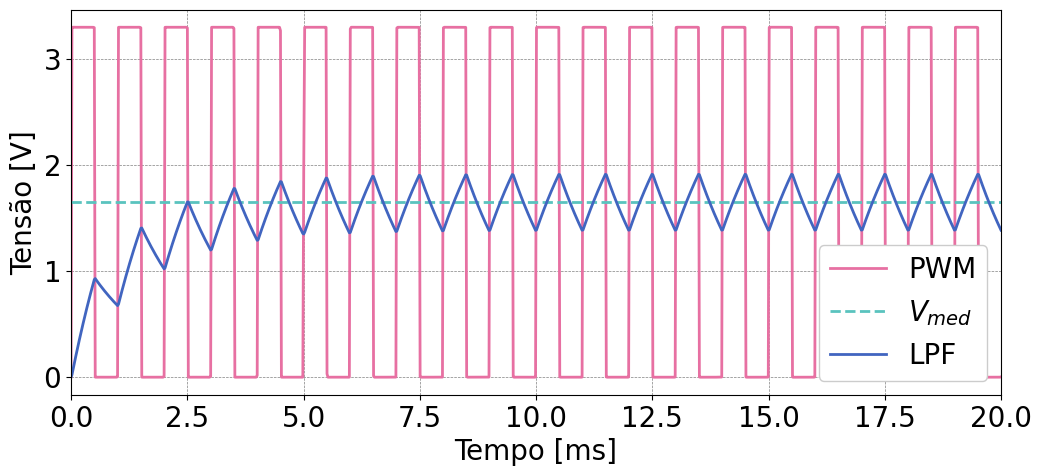

In [4]:
#Criação do vetor de tempo:
tf = 0.02
t = np.linspace(0, tf, 1000)

#Criação do sinal de entrada
f = 1e3
V = 3.3
D = 0.5
pwm = PWM(t, V, D, f)

#Tensão de Ripple:
ripp = ((D-(D**2))/(R*C*f))
print(f'Ripple: {int(ripp*V*1e3)}mV')

#Tempo de acomodação:
print(f'Tempo de acomodação: {int(4e3*tau)} ms')

#Simulação do sistema:
y = ct.forced_response(Grc, t, pwm)[1]

plt.figure()
plt.plot(t*1e3, pwm, color='C1', label='PWM')
plt.plot(t*1e3, np.ones(t.shape)*V*D, linestyle='dashed', color='C2', label='$V_{med}$')
plt.plot(t*1e3, y, color='C0', label='LPF')
plt.ylabel('Tensão [V]')
plt.xlabel('Tempo [ms]')
plt.xlim(0, tf*1e3)
plt.legend(loc='lower right')
plt.savefig('curves/lpf1.eps', dpi=600, transparent=True, bbox_inches='tight')

C:\Users\Erick\AppData\Local\Temp\ipykernel_12796\2535706612.py:17: RuntimeWarning: divide by zero encountered in divide
  ax2.plot(tauvals, ((D-(D**2))/((tauvals*1e-3)*f))*100, color='C4')


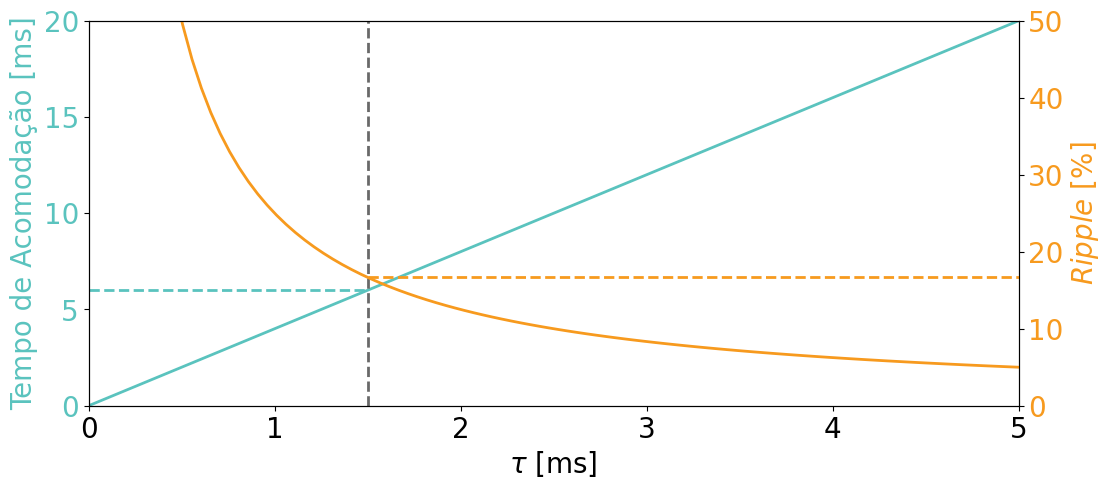

In [5]:
tauvals = np.linspace(0, 5, 100)

fig, ax1 = plt.subplots()  
  
ax1.set_xlabel('$\\tau$ [ms]')  
ax1.set_ylabel('Tempo de Acomodação [ms]', color='C2')  
ax1.plot(tauvals, 4*tauvals, color='C2')
ax1.plot((tau*1e3, tau*1e3), (0, 20), linestyle='dashed', color='C3')
ax1.plot((0, tau*1e3), (4e3*tau, 4e3*tau), linestyle='dashed', color='C2')
ax1.tick_params(axis ='y', labelcolor='C2')
ax1.set_xlim(0, 5)
ax1.set_ylim(0, 20)
plt.grid()
ax2 = ax1.twinx()  
  
ax2.set_ylabel('$Ripple$ [%]', color='C4')  
ax2.plot(tauvals, ((D-(D**2))/((tauvals*1e-3)*f))*100, color='C4')
ax2.plot((tau*1e3, 5), (ripp*100, ripp*100), linestyle='dashed', color='C4')
ax2.tick_params(axis ='y', labelcolor='C4')   
ax2.set_ylim(0, 50)
plt.grid()
plt.savefig('curves/optlpf.eps', dpi=600, transparent=True, bbox_inches='tight')

<h3 align='center'>Cascateamento (Filtros em Série):<h3>

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


Ripple: 15mV
Tempo de acomodação: 18 ms


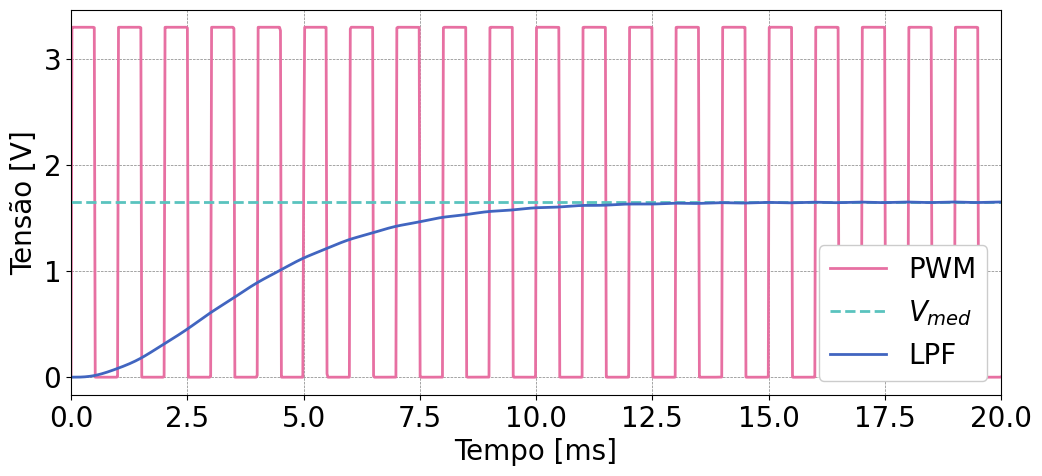

In [6]:
#Tensão de Ripple:
print(f'Ripple: {int((ripp**3)*V*1e3)}mV')

#Tempo de acomodação:
print(f'Tempo de acomodação: {int(4e3*tau*3)} ms')

#Simulação do sistema:
y = ct.forced_response(Grc*Grc*Grc, t, pwm)[1]

plt.figure()
plt.plot(t*1e3, pwm, color='C1', label='PWM')
plt.plot(t*1e3, np.ones(t.shape)*V*D, linestyle='dashed', color='C2', label='$V_{med}$')
plt.plot(t*1e3, y, color='C0', label='LPF')
plt.ylabel('Tensão [V]')
plt.xlabel('Tempo [ms]')
plt.xlim(0, tf*1e3)
plt.legend(loc='lower right')
plt.savefig('curves/lpf2.eps', dpi=600, transparent=True, bbox_inches='tight')

In [7]:
cte = (R*C)

fc = (1/(2*np.pi*cte))

Glpf = (1/((cte*s)+1))

Glpf

TransferFunction(array([1]), array([0.0015, 1.    ]))

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


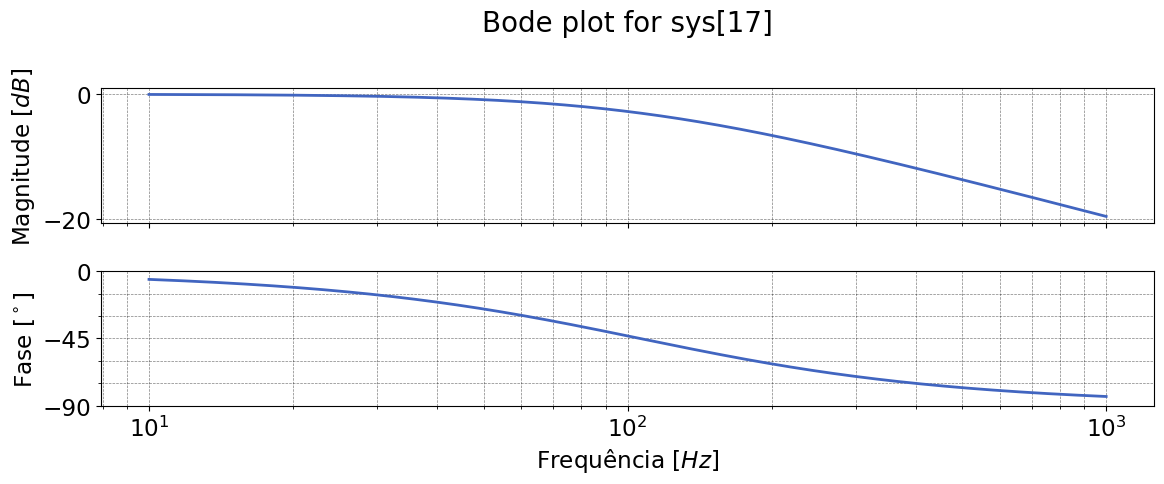

In [8]:
bd = ct.bode(Glpf, dB=True, Hz=True)
#plt.tight_layout()
ax1,ax2 = plt.gcf().axes     # get subplot axes

ax1.set_ylabel('Magnitude [$dB$]')
ax2.set_ylabel('Fase [$^\circ$]')
ax2.set_xlabel('Frequência [$Hz$]')

plt.savefig('curves/lpfbode.eps', dpi=600, transparent=True, bbox_inches='tight')

<h3 align='center'>RLC Low Pass Filter:<h3>

In [9]:
R = 1
L = 1.5e-3
C = 1000e-6

xc = (1/(s*C))
xl = (s*L)
zp = ((R*xc)/(R+xc))
z = (xl+zp)
tau = (2*R*L*C)

Grlc = ct.minreal(zp/z, verbose=False)

Grlc

TransferFunction(array([666666.66666667]), array([1.00000000e+00, 1.00000000e+03, 6.66666667e+05]))

In [10]:
ct.damp(Grlc)

    Eigenvalue (pole)       Damping     Frequency
      -500    +645.5j        0.6124         816.5
      -500    -645.5j        0.6124         816.5


(array([816.49658093, 816.49658093]),
 array([0.61237244, 0.61237244]),
 array([-500.+645.49722437j, -500.-645.49722437j]))

Ripple: 825mV
Tempo de acomodação: 0 ms


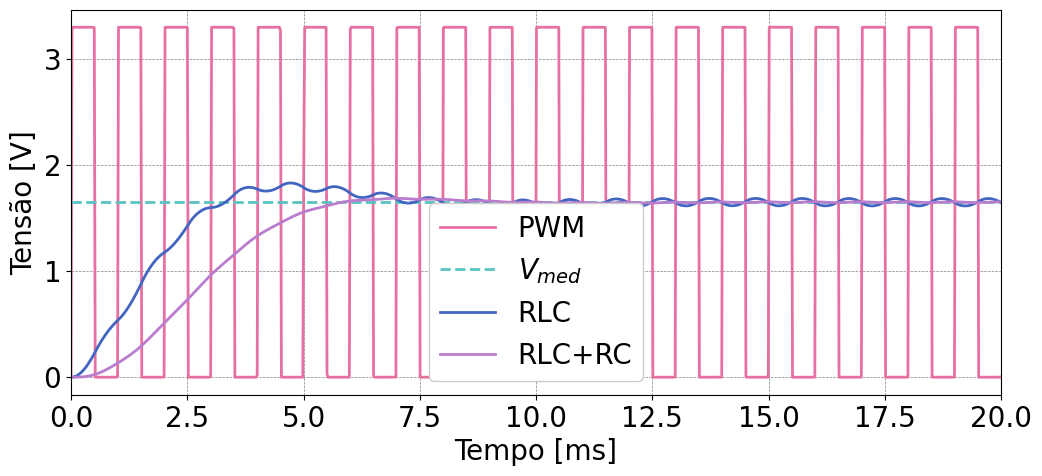

In [11]:
#Criação do vetor de tempo:
tf = 0.02
t = np.linspace(0, tf, 1000)

#Criação do sinal de entrada
f = 1e3
V = 3.3
D = 0.5
pwm = PWM(t, V, D, f)

#Tensão de Ripple:
ripp = ((D-(D**2))/(R*C*f))
print(f'Ripple: {int(ripp*V*1e3)}mV')

#Tempo de acomodação:
print(f'Tempo de acomodação: {int(4e3*tau)} ms')

#Simulação do sistema:
y1 = ct.forced_response(Grlc, t, pwm)[1]
y2 = ct.forced_response(Grc, t, y1)[1]

plt.figure()
plt.plot(t*1e3, pwm, color='C1', label='PWM')
plt.plot(t*1e3, np.ones(t.shape)*V*D, linestyle='dashed', color='C2', label='$V_{med}$')
plt.plot(t*1e3, y1, color='C0', label='RLC')
plt.plot(t*1e3, y2, color='C5', label='RLC+RC')
plt.ylabel('Tensão [V]')
plt.xlabel('Tempo [ms]')
plt.xlim(0, tf*1e3)
plt.legend(loc='lower center')
plt.show()

In [12]:
Grlc*Grc

TransferFunction(array([4.44444444e+08]), array([1.00000000e+00, 1.66666667e+03, 1.33333333e+06, 4.44444444e+08]))

Ripple: 825mV
Tempo de acomodação: 0 ms


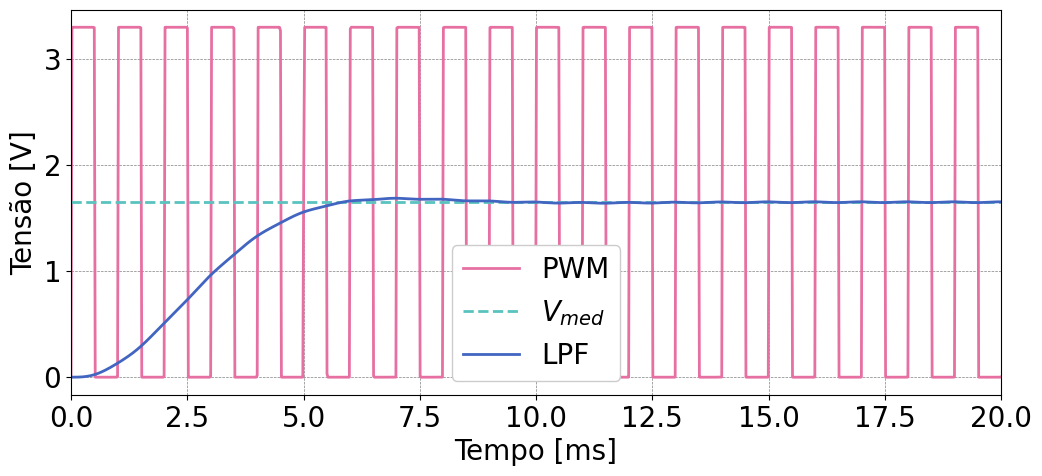

In [13]:
#Criação do vetor de tempo:
tf = 0.02
t = np.linspace(0, tf, 1000)

#Criação do sinal de entrada
f = 1e3
V = 3.3
D = 0.5
pwm = PWM(t, V, D, f)

#Tensão de Ripple:
ripp = ((D-(D**2))/(R*C*f))
print(f'Ripple: {int(ripp*V*1e3)}mV')

#Tempo de acomodação:
print(f'Tempo de acomodação: {int(4e3*tau)} ms')

#Simulação do sistema:
y = ct.forced_response(Grlc*Grc, t, pwm)[1]

plt.figure()
plt.plot(t*1e3, pwm, color='C1', label='PWM')
plt.plot(t*1e3, np.ones(t.shape)*V*D, linestyle='dashed', color='C2', label='$V_{med}$')
plt.plot(t*1e3, y, color='C0', label='LPF')
plt.ylabel('Tensão [V]')
plt.xlabel('Tempo [ms]')
plt.xlim(0, tf*1e3)
plt.legend(loc='lower center')
plt.show()